In [14]:
# !pip install python-binance
# !pip install python-dotenv
# !pip install pandas_ta

In [28]:
from binance.client import Client
import pandas as pd
from dotenv import load_dotenv 
import os
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler

In [51]:
# --- Imports para o treinamento e backtesting ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib # Para salvar e carregar o modelo e o scaler

# --- Novo import para visualização ---
import matplotlib.pyplot as plt

In [3]:
load_dotenv()

API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [32]:
if not API_KEY or not API_SECRET:
    print("Erro: As chaves API_KEY ou API_SECRET não foram carregadas do arquivo .env.")
    print("Verifique se o arquivo .env existe na mesma pasta e se as variáveis estão corretas.")
    exit() # Sai do programa se as chaves não forem encontradas

# 4. Inicializa o cliente da Binance (mesmo código de antes)
try:
    client = Client(API_KEY, API_SECRET)
    print("Conexão com a Binance estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar com a Binance: {e}")
    print("Verifique suas chaves de API e sua conexão com a internet.")
    exit()

# 5. Define os parâmetros para a busca dos dados de candlestick (mesmo código de antes)
symbol = 'BTCUSDT'
interval = '1h'
limit = 2500

print(f"\nBuscando os últimos {limit} candlesticks de {symbol} no intervalo de {interval}...")


Conexão com a Binance estabelecida com sucesso!

Buscando os últimos 2500 candlesticks de BTCUSDT no intervalo de 1h...


In [5]:
# 6. Faz a requisição para a API da Binance
klines = client.get_historical_klines(symbol, interval, limit=limit)


In [33]:
# 7. Processa os dados brutos e os organiza em um DataFrame do Pandas
data = []
for kline in klines:
    data.append({
        'timestamp': kline[0],
        'open': float(kline[1]),
        'high': float(kline[2]),
        'low': float(kline[3]),
        'close': float(kline[4]),
        'volume': float(kline[5])
    })

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Armazenar o DataFrame original antes de renomear colunas
# para que possamos usar 'close' para o cálculo do label
df_original_cols = df.copy()

# Assegura que as colunas numéricas estão no tipo correto para pandas_ta
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [52]:
# --- 8. Adicionar Indicadores Técnicos (Feature Engineering) ---
print("\nAdicionando indicadores técnicos ao DataFrame...")
df.ta.sma(length=20, append=True)
df.ta.bbands(append=True)
df.ta.rsi(length=14, append=True)
print("Indicadores adicionados com sucesso!")


Adicionando indicadores técnicos ao DataFrame...
Indicadores adicionados com sucesso!


In [25]:
# --- 9 Tratamento de Valores NaN ---
print("\nTratando valores NaN...")

# Guarda o número de linhas antes de remover os NaNs
initial_rows = len(df)

# Remove todas as linhas que contêm qualquer valor NaN
df.dropna(inplace=True)

# Guarda o número de linhas depois de remover os NaNs
final_rows = len(df)

print(f"Número de linhas antes do tratamento de NaN: {initial_rows}")
print(f"Número de linhas após o tratamento de NaN: {final_rows}")
print(f"Total de linhas removidas: {initial_rows - final_rows}")


Tratando valores NaN...
Número de linhas antes do tratamento de NaN: 500
Número de linhas após o tratamento de NaN: 481
Total de linhas removidas: 19


In [29]:
# ### **10. Normalização/Escalonamento de Dados (StandardScaler)**
# print("\nRealizando o escalonamento dos dados (StandardScaler)...")
# # Certifique-se de que todas as colunas sejam numéricas antes de escalonar
# features_to_scale = df.columns.tolist()
# # Cria uma instância do StandardScaler
# scaler = StandardScaler()
# # O resultado é um array NumPy, então o convertemos de volta para um DataFrame.
# df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]),
#                          columns=features_to_scale,
#                          index=df.index)

# print("Escalonamento concluído!")


Realizando o escalonamento dos dados (StandardScaler)...
Escalonamento concluído!


In [53]:
# --- 10. Criação dos Labels (Comprar/Vender/Manter) ---
print("\nCriando os labels de Comprar/Vender/Manter...")
look_forward_period = 5
price_change_threshold = 0.005

df['future_close'] = df['Close'].shift(-look_forward_period)
df['price_change'] = (df['future_close'] - df['Close']) / df['Close']

def get_label(change, threshold):
    if change > threshold:
        return 1
    elif change < -threshold:
        return -1
    else:
        return 0

df['label'] = df['price_change'].apply(lambda x: get_label(x, price_change_threshold))

df.drop(columns=['future_close', 'price_change'], inplace=True)
df.dropna(inplace=True)
print("Labels criados com sucesso!")


Criando os labels de Comprar/Vender/Manter...
Labels criados com sucesso!


In [54]:
# 11. Dividir em Features (X) e Labels (y)
X = df.drop(columns=['label'])
y = df['label']

# Re-escalonar X e salvar o scaler
features_to_scale_final = X.columns.tolist()
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[features_to_scale_final]),
                        columns=features_to_scale_final,
                        index=X.index)
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler salvo como 'scaler.pkl' para uso em previsões futuras.")



Scaler salvo como 'scaler.pkl' para uso em previsões futuras.


In [55]:
# 12. Divisão dos Dados em Conjuntos de Treino e Teste
print("\nDividindo os dados em conjuntos de treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)
print(f"Tamanho do conjunto de treino (X_train): {len(X_train)} linhas")
print(f"Tamanho do conjunto de teste (X_test): {len(X_test)} linhas")


Dividindo os dados em conjuntos de treino e teste...
Tamanho do conjunto de treino (X_train): 384 linhas
Tamanho do conjunto de teste (X_test): 97 linhas


In [56]:
# 13. Otimização e Treinamento do Modelo com GridSearchCV
print("\nIniciando a otimização do modelo com GridSearchCV...")
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100], # Reduzindo para agilizar o exemplo de backtesting
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=0, n_jobs=-1) # Reduzindo cv e verbose
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'modelo_random_forest_otimizado.pkl')
print(f"\nMelhores hiperparâmetros encontrados: {grid_search.best_params_}")
print("Treinamento e otimização concluídos. Modelo salvo como 'modelo_random_forest_otimizado.pkl'.")



Iniciando a otimização do modelo com GridSearchCV...

Melhores hiperparâmetros encontrados: {'max_depth': 10, 'n_estimators': 50}
Treinamento e otimização concluídos. Modelo salvo como 'modelo_random_forest_otimizado.pkl'.


In [57]:
# 14. Avaliação do Melhor Modelo (Revisado para usar o carregado)
print("\nCarregando modelo e scaler para avaliação e backtesting...")
loaded_scaler = joblib.load('scaler.pkl')
loaded_model = joblib.load('modelo_random_forest_otimizado.pkl')

y_pred_optimized = loaded_model.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"\nAcurácia do modelo otimizado no conjunto de teste: {accuracy_optimized:.4f}")
print("\nRelatório de Classificação do Modelo Otimizado:")
print(classification_report(y_test, y_pred_optimized))
print("\nMatriz de Confusão do Modelo Otimizado:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print(cm_optimized)


Carregando modelo e scaler para avaliação e backtesting...

Acurácia do modelo otimizado no conjunto de teste: 0.6804

Relatório de Classificação do Modelo Otimizado:
              precision    recall  f1-score   support

          -1       0.70      0.44      0.54        16
           0       0.70      0.89      0.78        62
           1       0.50      0.21      0.30        19

    accuracy                           0.68        97
   macro avg       0.63      0.51      0.54        97
weighted avg       0.66      0.68      0.65        97


Matriz de Confusão do Modelo Otimizado:
[[ 7  9  0]
 [ 3 55  4]
 [ 0 15  4]]



--- Iniciando Backtesting da Estratégia ---
Capital inicial: 10000.00 USDT
Venda final da posição no último preço: 108096.75

--- Resultados do Backtest ---
Capital inicial: 10000.00 USDT
Capital final: 10284.53 USDT
Lucro/Prejuízo: 284.53 USDT
Retorno percentual: 2.85%
Número total de trades: 9


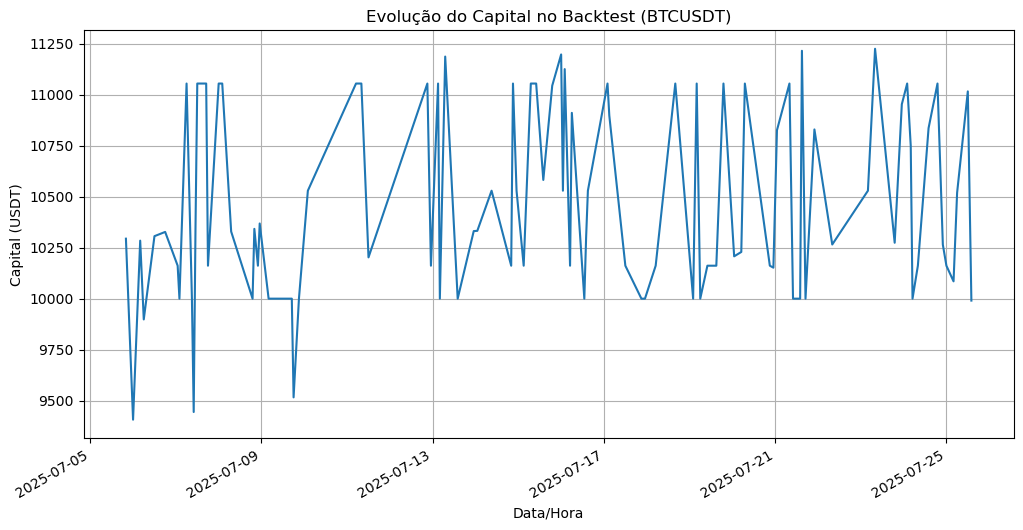


--- Backtesting Concluído ---


In [58]:
### **15. Backtesting da Estratégia**

print("\n--- Iniciando Backtesting da Estratégia ---")

# Parâmetros de backtesting
initial_capital = 10000.0 # Capital inicial em USDT
position_size_percentage = 0.95 # % do capital para alocar em cada trade (ex: 95%)
commission_rate = 0.001 # Taxa de comissão da Binance (0.1% para maker/taker)

# Prepara os dados de teste para o backtesting
# Usamos o DataFrame original 'df' para obter os preços de fechamento reais
# e o X_test (escalonado) para as previsões do modelo.
# Garantimos que os índices são os mesmos.
backtest_df = df.loc[X_test.index].copy() # Pega apenas as linhas que estão no X_test
backtest_df['predicted_label'] = y_pred_optimized # Adiciona as previsões do modelo
backtest_df['true_label'] = y_test # Adiciona os labels reais para comparação

# Variáveis de controle para o backtesting
capital = initial_capital
position = 0.0 # Quantidade do ativo base que temos (ex: BTC)
in_position = False # Flag para saber se estamos comprados

trade_log = [] # Para registrar os trades

print(f"Capital inicial: {capital:.2f} USDT")

# Loop através dos dados do backtest candle por candle
for index, row in backtest_df.iterrows():
    current_price = row['Close'] # Preço de fechamento real do candle
    prediction = row['predicted_label'] # Previsão do nosso modelo

    # Lógica de Compra
    if prediction == 1 and not in_position: # Se o modelo previu "comprar" e não estamos em posição
        amount_to_buy_usdt = capital * position_size_percentage
        if amount_to_buy_usdt > 0:
            qty_to_buy = amount_to_buy_usdt / current_price
            commission_cost = qty_to_buy * current_price * commission_rate
            
            capital -= (qty_to_buy * current_price) + commission_cost
            position += qty_to_buy
            in_position = True
            
            trade_log.append({
                'timestamp': index,
                'type': 'BUY',
                'price': current_price,
                'qty': qty_to_buy,
                'commission': commission_cost,
                'capital_after_trade': capital,
                'position_after_trade': position
            })
            # print(f"{index}: BUY @ {current_price:.2f} | Capital: {capital:.2f} | Pos: {position:.4f}")

    # Lógica de Venda
    elif prediction == -1 and in_position: # Se o modelo previu "vender" e estamos em posição
        commission_cost = position * current_price * commission_rate
        
        capital += (position * current_price) - commission_cost
        position = 0.0
        in_position = False
        
        trade_log.append({
            'timestamp': index,
            'type': 'SELL',
            'price': current_price,
            'qty': position, # Qtde vendida é a que tínhamos
            'commission': commission_cost,
            'capital_after_trade': capital,
            'position_after_trade': position
        })
        # print(f"{index}: SELL @ {current_price:.2f} | Capital: {capital:.2f} | Pos: {position:.4f}")

# Calcular capital final (se ainda estiver em posição, vende no último preço)
if in_position:
    commission_cost = position * backtest_df.iloc[-1]['Close'] * commission_rate
    capital += (position * backtest_df.iloc[-1]['Close']) - commission_cost
    position = 0.0
    print(f"Venda final da posição no último preço: {backtest_df.iloc[-1]['Close']:.2f}")

final_capital = capital
profit_loss_usd = final_capital - initial_capital
profit_loss_percent = (profit_loss_usd / initial_capital) * 100

print("\n--- Resultados do Backtest ---")
print(f"Capital inicial: {initial_capital:.2f} USDT")
print(f"Capital final: {final_capital:.2f} USDT")
print(f"Lucro/Prejuízo: {profit_loss_usd:.2f} USDT")
print(f"Retorno percentual: {profit_loss_percent:.2f}%")
print(f"Número total de trades: {len(trade_log)}")

# Opcional: Visualização do saldo ao longo do tempo
if len(trade_log) > 0:
    trade_df = pd.DataFrame(trade_log)
    trade_df.set_index('timestamp', inplace=True)
    
    # Para visualizar a evolução do capital, precisamos preencher entre os trades
    # Criar uma série para o capital ao longo do tempo
    capital_history = pd.Series(index=backtest_df.index, dtype=float)
    current_capital_viz = initial_capital
    current_position_viz = 0.0
    
    for index_df, row_df in backtest_df.iterrows():
        # Se houve trade nesse timestamp, atualiza o capital e posição
        trade_at_ts = trade_df[trade_df.index == index_df]
        if not trade_at_ts.empty:
            current_capital_viz = trade_at_ts.iloc[0]['capital_after_trade']
            current_position_viz = trade_at_ts.iloc[0]['position_after_trade']
            
        # Calcula o valor total do portfólio (capital + valor da posição)
        portfolio_value = current_capital_viz + (current_position_viz * row_df['Close'])
        capital_history.loc[index_df] = portfolio_value
        
    plt.figure(figsize=(12, 6))
    capital_history.plot(title=f'Evolução do Capital no Backtest ({symbol})')
    plt.xlabel('Data/Hora')
    plt.ylabel('Capital (USDT)')
    plt.grid(True)
    plt.show()
else:
    print("Nenhum trade foi executado durante o backtest.")


print("\n--- Backtesting Concluído ---")